In [1]:
import sys
sys.path.append('..')

import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

import optuna

from eli5.sklearn import PermutationImportance

from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators


class CFG:
    load = False
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = True
    optimize = True
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

# Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

# Check if all dataframes has data for both timeframes 1h and 4h

In [4]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare data

In [19]:
# Get configs
configs = ConfigFactory.factory(environ).configs
higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                   'macd_dir', 'macdsignal', 'macdsignal_dir']
price_cols = ['real_high', 'real_low', 'real_close']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time_4h'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[['time'] + higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', left_on='time', right_on='time_4h')
    df.drop(columns=['time_4h', 'close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    df_higher.drop(columns=['time_4h'], inplace=True)
    df.ffill(inplace=True)
    # MinMax scale price and volume columns
    df[price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in price_cols]].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set sl flag and exit cycle if price crosses stop-loss threshold before it crosses take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1
                sl3 = pattern.startswith('Pattern') and ttype == 'buy' and target_sell_sl == 1
                sl4 = pattern.startswith('Pattern') and ttype == 'sell' and target_buy_sl == 1
                
                if sl1 or sl2 or sl3 or sl4:
                    break

                # set tp flag and exit cycle if price cross take-profit threshold and doesn't cross stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                tp3 = pattern.startswith('Pattern') and ttype == 'buy' and target_buy_tp == 1
                tp4 = pattern.startswith('Pattern') and ttype == 'sell' and target_sell_tp == 1
                    
                if tp1 or tp2 or tp3 or tp4:
                    row['target'] = 1
                    break
                
                # if price doesn't cross both tp and sl threshold but price above / below enter price for buy / sell trade - set tp flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price
                    l3 = pattern.startswith('Pattern') and ttype == 'buy' and last_price > close_price
                    l4 = pattern.startswith('Pattern') and ttype == 'sell' and last_price < close_price

                    if l1 or l2 or l3 or l4:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=price_cols)
    return train_df

if CFG.create_dataset:
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    df = df[df['time'].dt.hour.isin([0, 1, 2, 3, 15, 16, 21, 22, 23])]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    df = df[df['time'].dt.hour.isin([1, 2, 11, 14, 16, 17, 19, 21])]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    display(train_sell.head())
    display(train_sell.shape)


  0%|          | 0/814 [00:00<?, ?it/s]

# Check pattern / target distribution

In [6]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

if CFG.create_dataset:
    pvt = train_buy  # df[df['ttype'] == 'buy']
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)
    display(pvt[pvt['pct'] >= 0.518])

    pvt = train_sell  # df[df['ttype'] == 'sell']
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)
    display(pvt[pvt['pct'] >= 0.518])

    display(train_buy['ttype'].value_counts())
    display(train_sell['ttype'].value_counts())

    display(train_buy[['target', 'pattern']].value_counts())
    display(train_buy[['target', 'pattern']].value_counts(normalize=True))
    display(train_sell[['target', 'pattern']].value_counts())
    display(train_sell[['target', 'pattern']].value_counts(normalize=True))

,hour,target,count,total,pct,trust_interval
1,0,1,557,1049,0.530982,"(0.5009, 0.561)"
7,3,1,743,1423,0.522136,"(0.4963, 0.548)"
17,23,1,578,1034,0.558994,"(0.5289, 0.5891)"


,hour,target,count,total,pct,trust_interval


buy    10854
Name: ttype, dtype: int64

sell    6520
Name: ttype, dtype: int64

target  pattern           
0       STOCH_RSI_Volume24    5507
1       STOCH_RSI_Volume24    5347
dtype: int64

target  pattern           
0       STOCH_RSI_Volume24    0.507371
1       STOCH_RSI_Volume24    0.492629
dtype: float64

target  pattern           
0       STOCH_RSI_Volume24    3416
1       STOCH_RSI_Volume24    3104
dtype: int64

target  pattern           
0       STOCH_RSI_Volume24    0.523926
1       STOCH_RSI_Volume24    0.476074
dtype: float64

# Check target corectness

In [7]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

# Compare indicator / signal values for bot and optimizer

In [8]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'IOTAUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])

# Check buy trades correctness

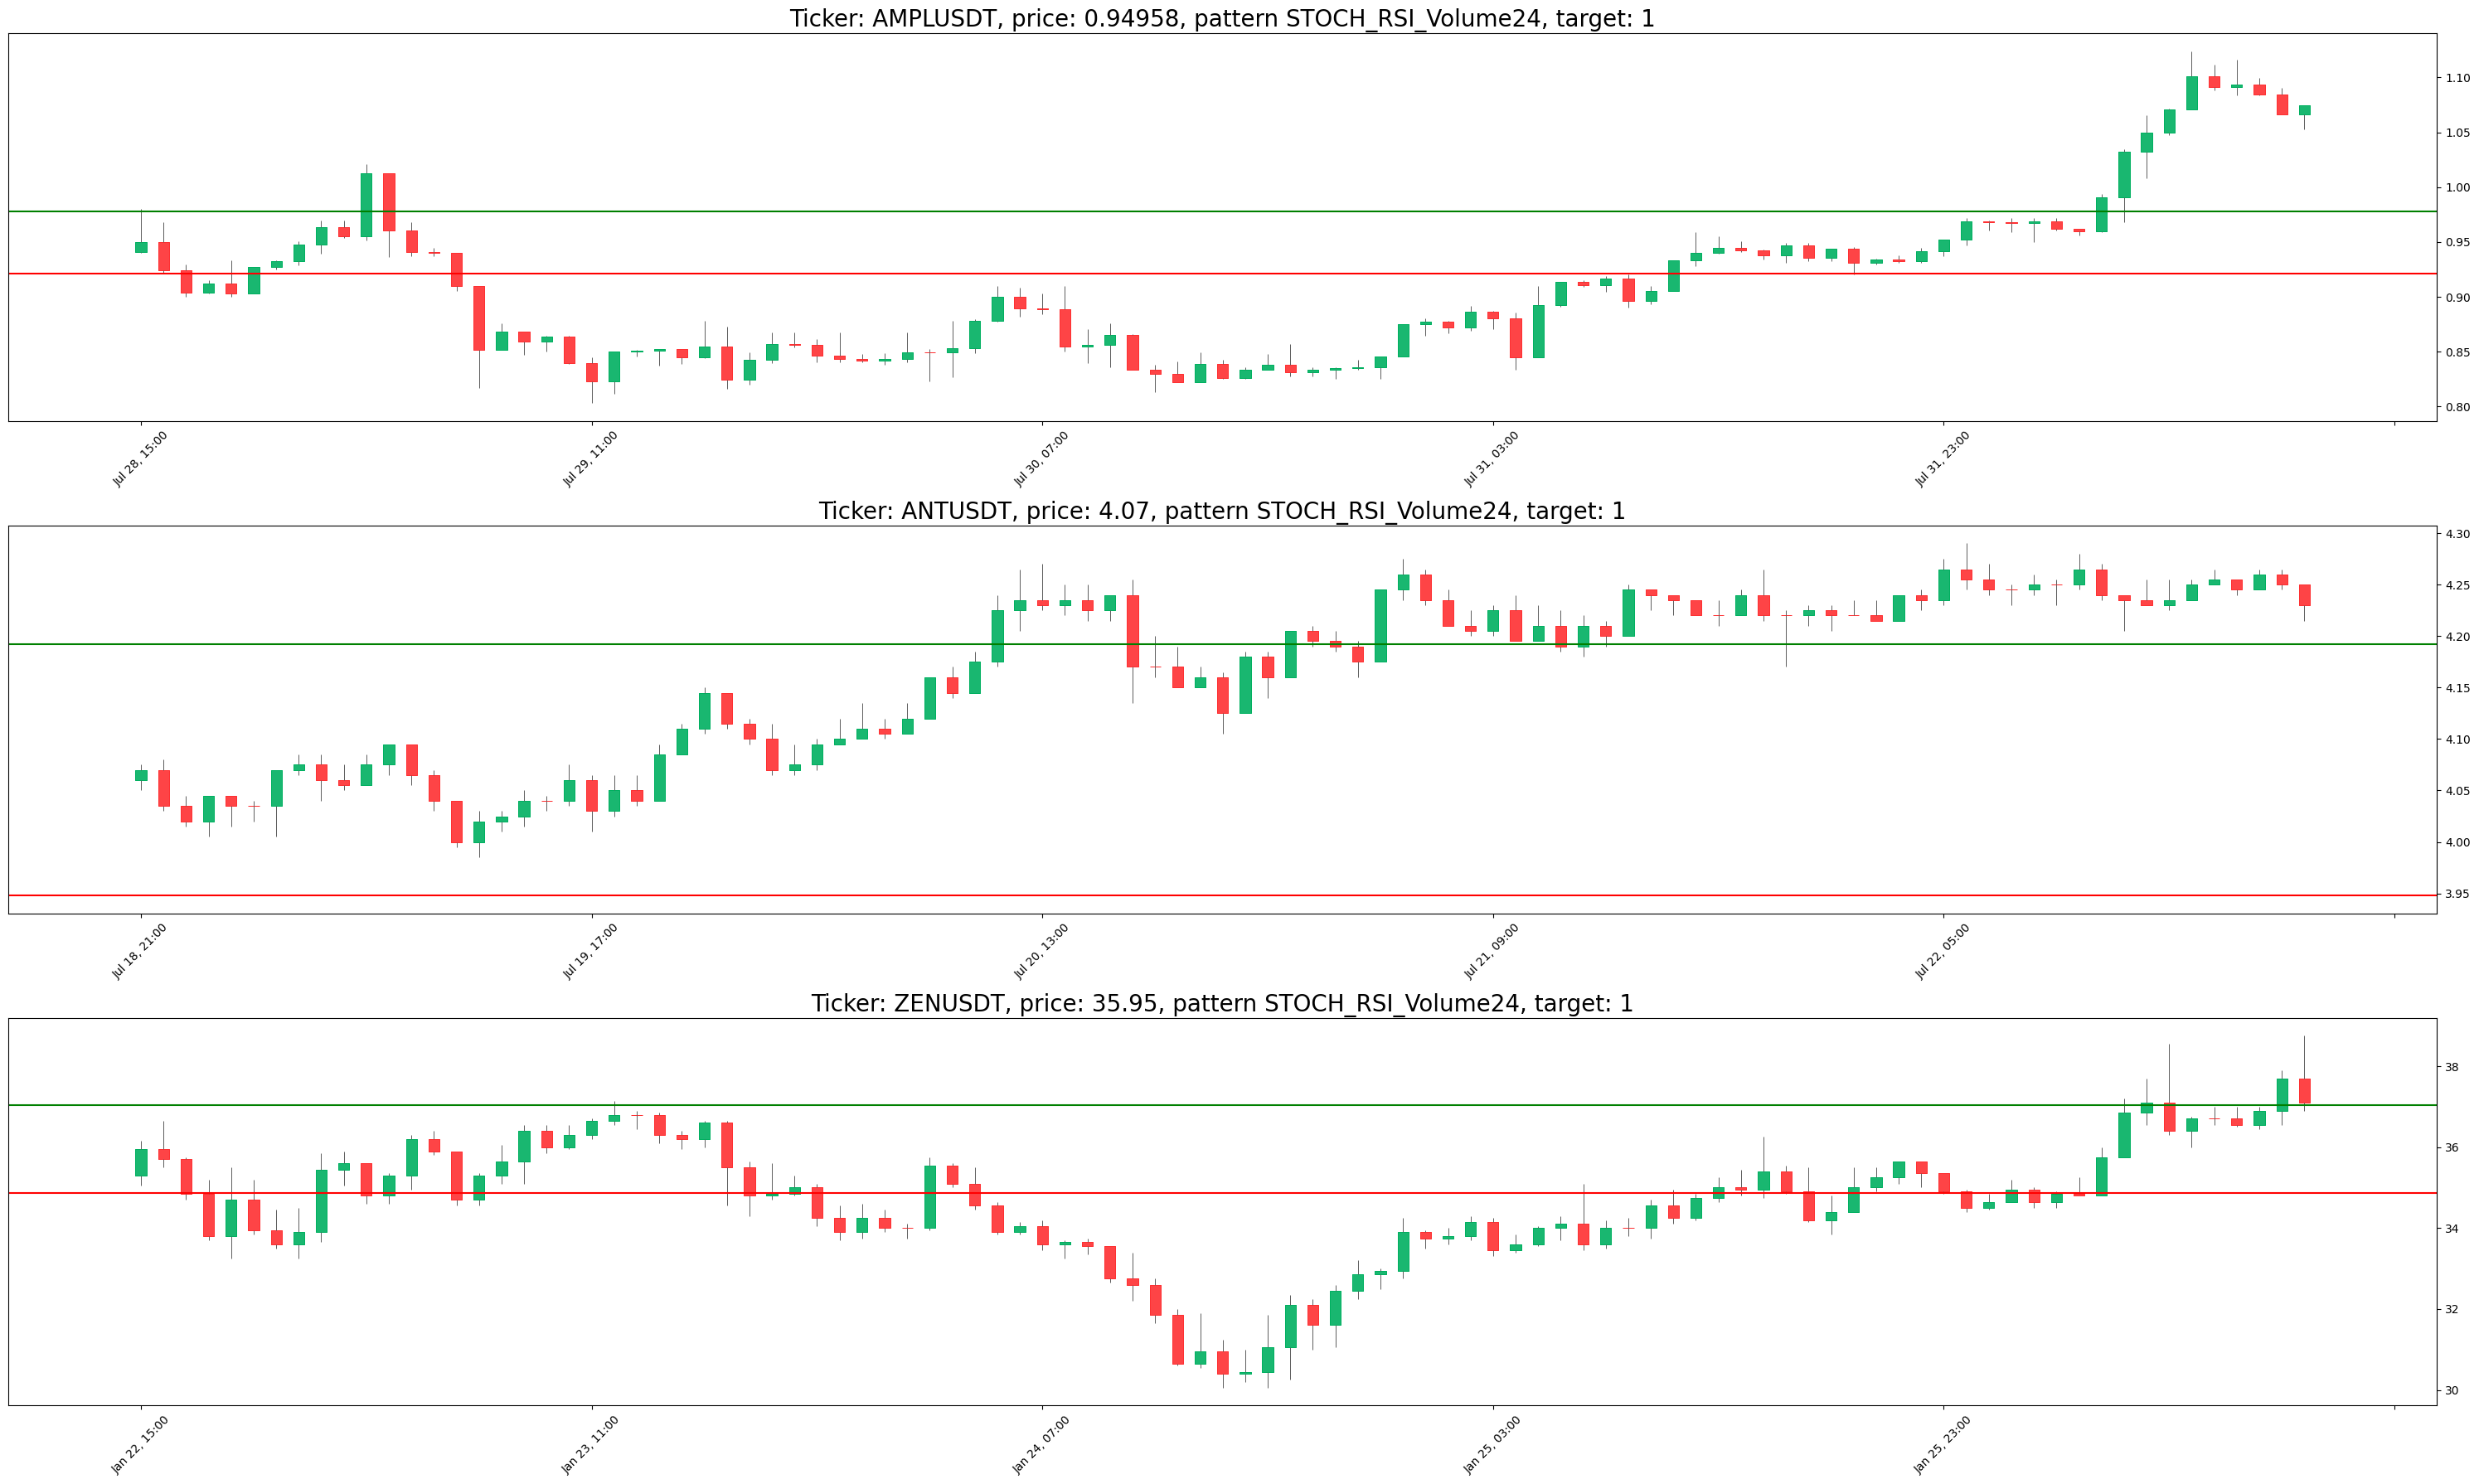

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check sell trades correctness

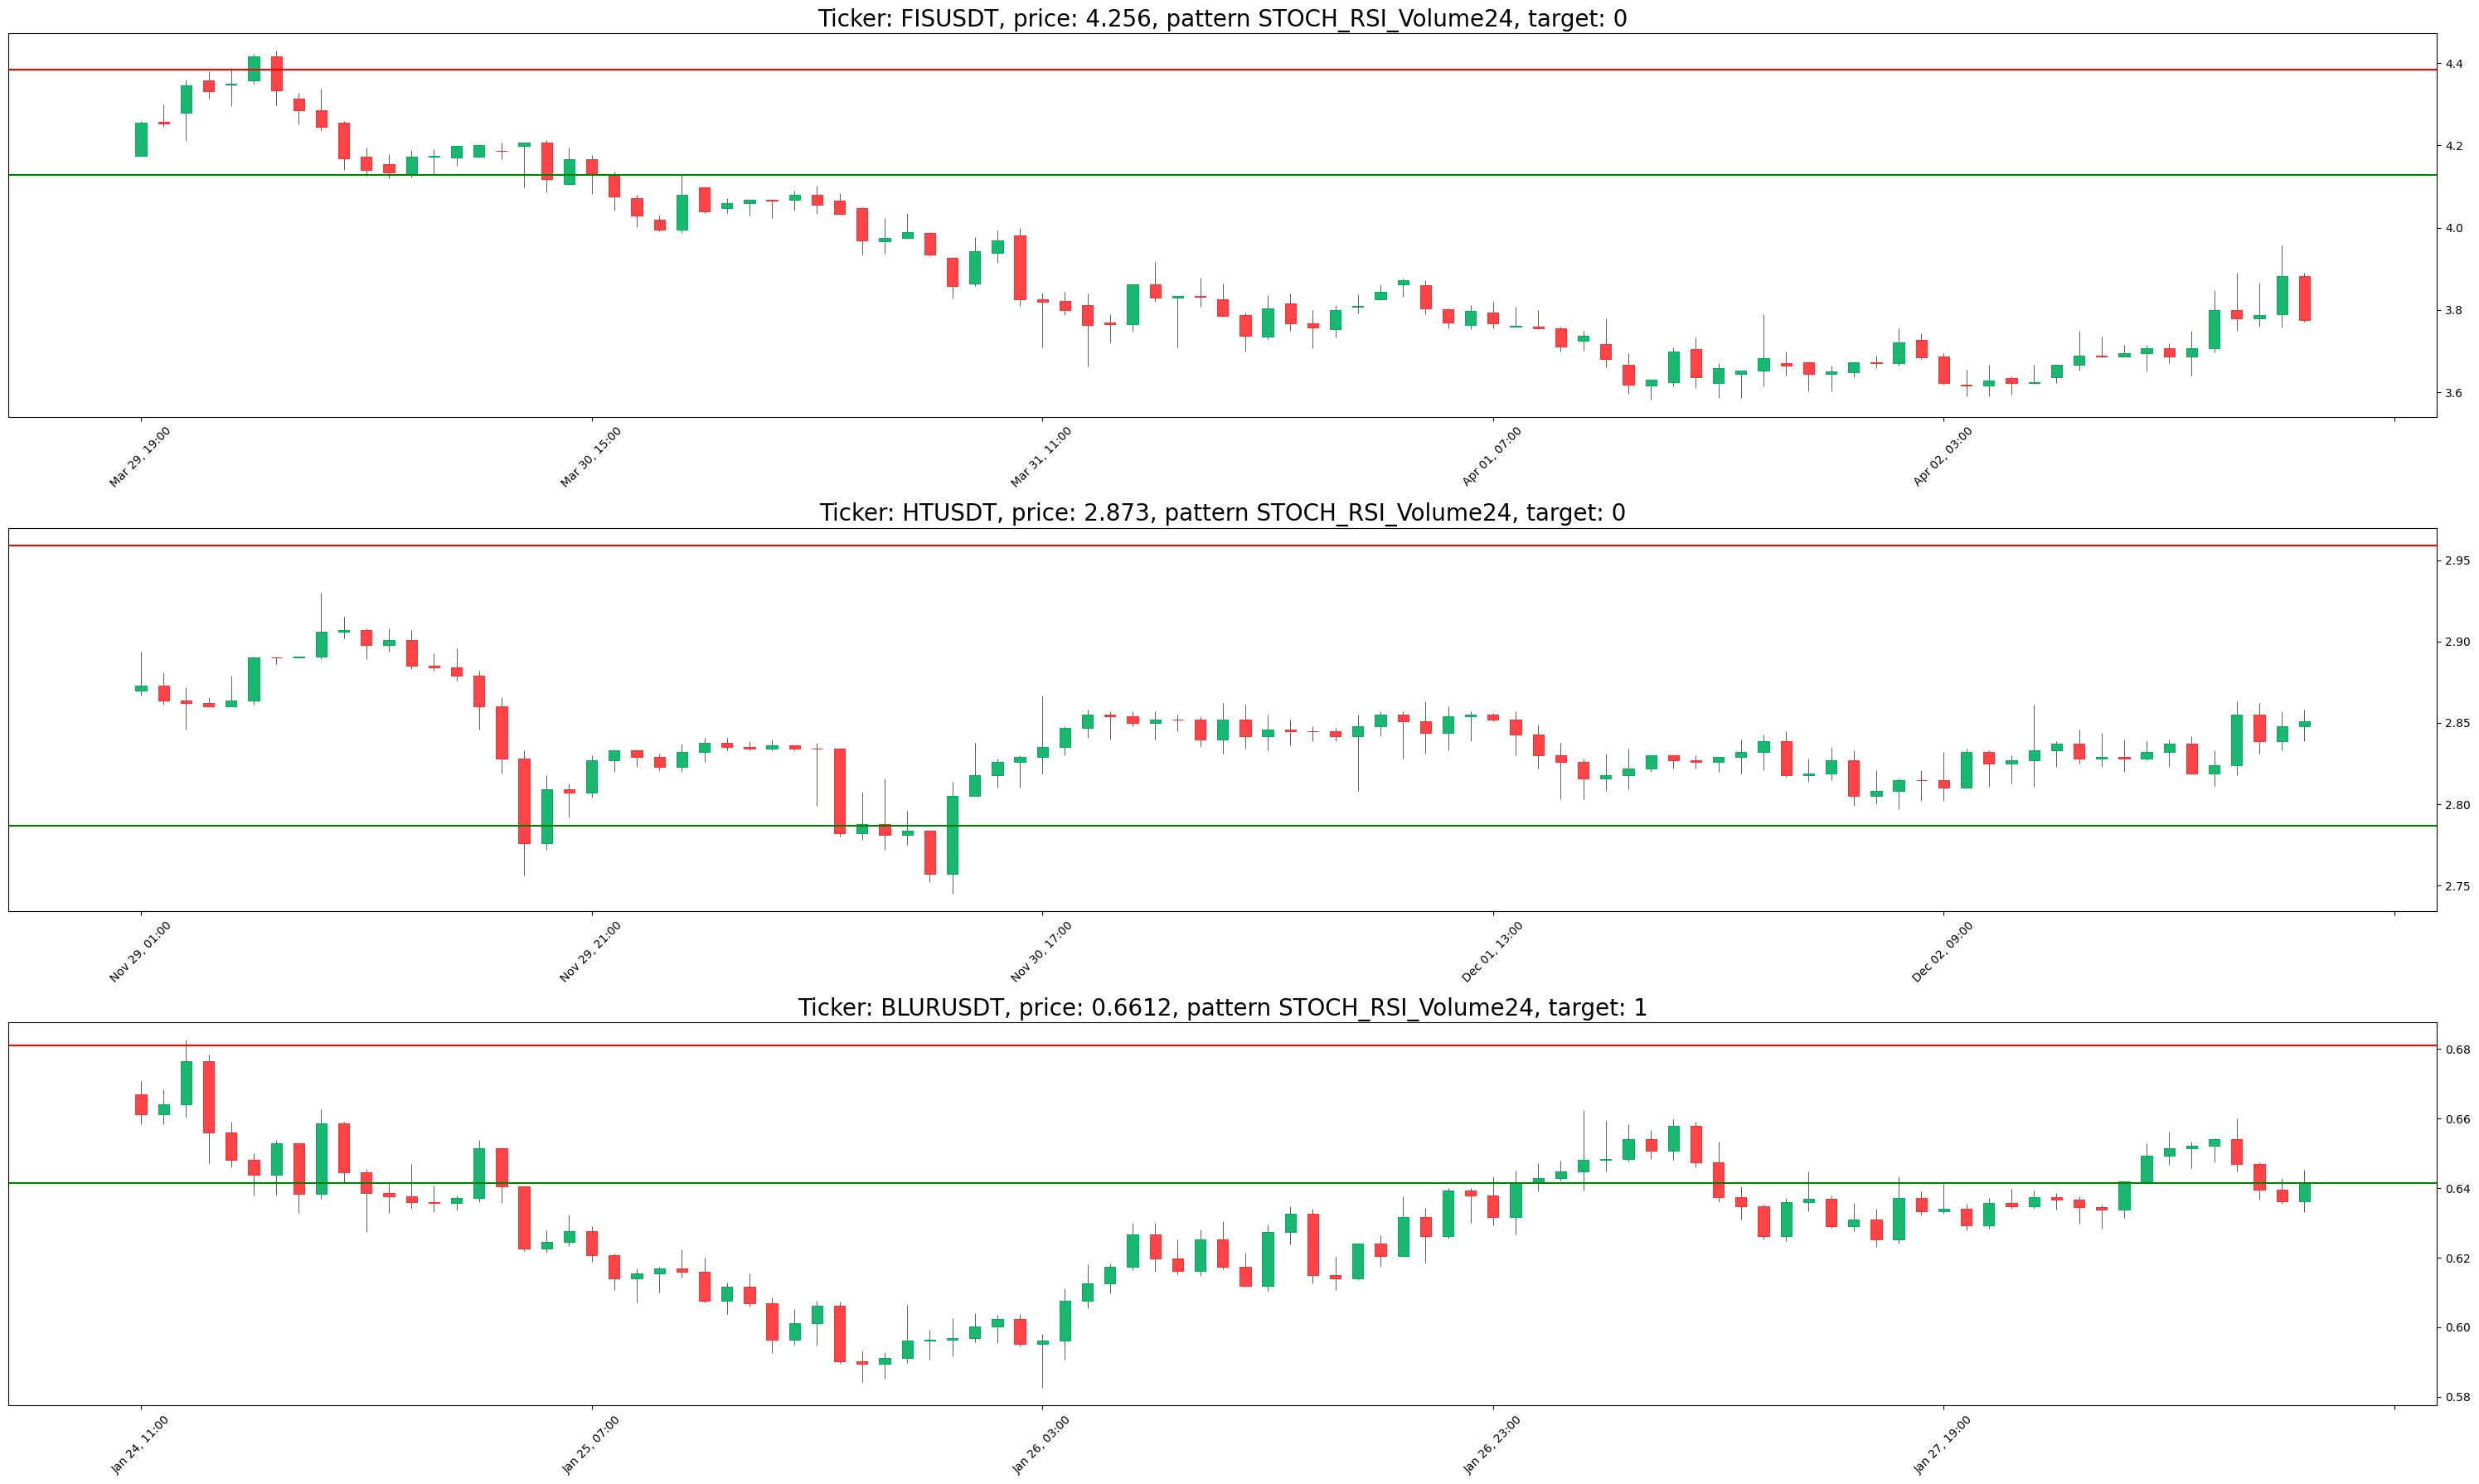

In [10]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

<AxesSubplot:>

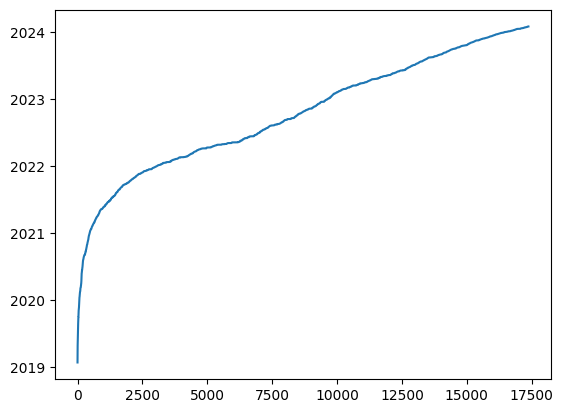

In [11]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

df = df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
df = df[df['time'] < df['time'].max()].reset_index(drop=True)

df['time'].plot()


# Visualize feature distributions

In [12]:
# import seaborn as sns

# fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
# cols = [c for c in fi if 'prev' not in c]
# figsize = (20, 30)

# def plot_target_violine(df, df_cols, n_rows, n_cols, target):
#     fig = plt.figure(figsize=figsize)
    
#     for idx, col in enumerate(df_cols):
#         ax = plt.subplot(n_rows, n_cols, idx + 1)
#         sns.violinplot(x=target, y=col, data=df)

#         ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
#         ax.set_xlabel(''); ax.spines['right'].set_visible(False)
#         ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
#     fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
#     # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
#     plt.tight_layout()
#     plt.show()
    
# plot_target_violine(df, cols, n_rows=7, n_cols=3, target='target') 

# Check the last signals

In [13]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
# x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
53789,2024-02-01 09:00:00,CLVUSDT,buy,STOCH_RSI_Volume24
53790,2024-02-01 09:00:00,KAVAUSDT,buy,STOCH_RSI_Volume24
53791,2024-02-01 09:00:00,RAYUSDT,buy,STOCH_RSI_Volume24
53792,2024-02-01 09:00:00,ARDRUSDT,buy,STOCH_RSI_Volume24
53793,2024-02-01 09:00:00,OPUSDT,buy,STOCH_RSI_Volume24
53794,2024-02-01 09:00:00,PERPUSDT,buy,STOCH_RSI_Volume24
53795,2024-02-01 09:00:00,ALTLAYERUSDT,buy,STOCH_RSI_Volume24
53796,2024-02-01 09:00:00,HIVEUSDT,buy,STOCH_RSI_Volume24
53797,2024-02-01 09:00:00,SEIUSDT,buy,STOCH_RSI_Volume24
53798,2024-02-01 09:00:00,ALTUSDT,buy,STOCH_RSI_Volume24


# Select features with BORUTA feature importance

In [14]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=300)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(df)

Fold: 0


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


KeyboardInterrupt: 

# Select features with permutation importance and GBM feature importance

In [ ]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

Repeat #1
[100]	valid_0's binary_logloss: 0.692323	valid_0's average_precision: 0.570666
[200]	valid_0's binary_logloss: 0.694659	valid_0's average_precision: 0.569599
[300]	valid_0's binary_logloss: 0.697023	valid_0's average_precision: 0.565932
[400]	valid_0's binary_logloss: 0.700744	valid_0's average_precision: 0.565162
[500]	valid_0's binary_logloss: 0.701972	valid_0's average_precision: 0.565217
[600]	valid_0's binary_logloss: 0.701548	valid_0's average_precision: 0.568305
[700]	valid_0's binary_logloss: 0.702222	valid_0's average_precision: 0.57081
[800]	valid_0's binary_logloss: 0.701888	valid_0's average_precision: 0.575229
[900]	valid_0's binary_logloss: 0.70216	valid_0's average_precision: 0.579717
[1000]	valid_0's binary_logloss: 0.704024	valid_0's average_precision: 0.578048
Fold:   1| loss: 0.70402| Best iteration:    0
[100]	valid_0's binary_logloss: 0.69414	valid_0's average_precision: 0.534671
[200]	valid_0's binary_logloss: 0.69669	valid_0's average_precision: 0.53696

# RFE feature selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(df)

Fitting estimator with 735 features.
Fitting estimator with 717 features.
Fitting estimator with 699 features.
Fitting estimator with 681 features.
Fitting estimator with 663 features.
Fitting estimator with 645 features.
Fitting estimator with 627 features.
Fitting estimator with 609 features.
Fitting estimator with 591 features.
Fitting estimator with 573 features.
Fitting estimator with 555 features.
Fitting estimator with 537 features.
Fitting estimator with 519 features.
Fitting estimator with 501 features.
Fitting estimator with 483 features.
Fitting estimator with 465 features.
Fitting estimator with 447 features.
Fitting estimator with 429 features.
Fitting estimator with 411 features.
Fitting estimator with 393 features.
Fitting estimator with 375 features.
Fitting estimator with 357 features.
Fitting estimator with 339 features.
Fitting estimator with 321 features.
Fitting estimator with 303 features.
Fitting estimator with 285 features.
Fitting estimator with 267 features.
F

# Combine importances and save them

In [ ]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

# Prepare features

In [ ]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

df['weekday'] = df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 69
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']

# Remove features that correlate with other features too much and are not so important

In [ ]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

{'atr_prev_9',
 'high_prev_1',
 'linear_reg_angle_prev_13',
 'linear_reg_angle_prev_21',
 'linear_reg_angle_prev_29',
 'linear_reg_angle_prev_33',
 'linear_reg_angle_prev_41',
 'linear_reg_prev_5',
 'macdhist_prev_173',
 'rsi',
 'rsi_prev_161',
 'rsi_prev_165',
 'rsi_prev_173',
 'rsi_prev_185',
 'rsi_prev_45',
 'rsi_prev_61',
 'rsi_prev_97',
 'stoch_slowd',
 'stoch_slowd_prev_1',
 'stoch_slowd_prev_133',
 'stoch_slowd_prev_25',
 'stoch_slowd_prev_29',
 'stoch_slowd_prev_49',
 'stoch_slowd_prev_89',
 'stoch_slowd_prev_97',
 'stoch_slowk',
 'stoch_slowk_prev_173',
 'stoch_slowk_prev_65',
 'stoch_slowk_prev_69',
 'stoch_slowk_prev_89',
 'volume_prev_1',
 'volume_prev_5'}

# Functions for train and optimization

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)
params_svc = {'probability': True}

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(train_df, features, params, params_svc, n_folds, low_bound, high_bound, train_test, weight=0.5, verbose=False): 
    X, time = train_df[features], train_df['time']
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (train_df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts())
                display(train_df.loc[val_idx[0], 'time'])
                display(train_df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_svc = make_pipeline(StandardScaler(), SVC(**params_svc))
            model_svc.fit(X_train, y_train)
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds_svc = model_svc.predict_proba(X_val)
            val_preds_lgb = model_lgb.predict_proba(X_val)
            val_preds = np.average([val_preds_svc, val_preds_lgb], weights=[weight, 1-weight], axis=0)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                    f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                    f'Number of profitable objects: {round(prec_obj_num * prec_score - prec_obj_num * (1 -prec_score))}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, [model_lgb, model_svc], sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = train_df[features], train_df['target']
        
        model_svc = make_pipeline(StandardScaler(), SVC(**params_svc))
        model_svc.fit(X, y)
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([train_df.shape[0], 1]), [model_lgb, model_svc], None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 128),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq':1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'weight': trial.suggest_float('weight', 0, 1),
        
        'C': trial.suggest_float('C', 1e-8, 10.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']), 
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']), 
        'shrinking': trial.suggest_categorical('shrinking', [True, False]), 
        'decision_function_shape': trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr']), 
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    if params['boosting_type'] != 'dart':
        params['early_stopping_round'] = 100

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']

    weight = params['weight']
    del params['weight']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']

    for p in ['C', 'kernel', 'gamma', 'shrinking', 'decision_function_shape']:
        params_svc[p] = params[p]
        del params[p]
    
    df['weekday'] = df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(df, features, params, params_svc, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold', weight=weight)
    
    y = df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, ___ = confident_score(y, oof, low_bound, high_bound)
    res = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    return res
    

# Train / optimize

In [ ]:
params = {
    'boosting_type': 'dart',
    'n_estimators': 878,
    'learning_rate': 0.0114275,
    'max_depth': 6,
    'colsample_bytree': 0.785,
    'subsample': 0.3952,
    'subsample_freq': 1,
    'num_leaves': 93,
    'verbosity': -1,
    'max_bin': 36,
    'reg_alpha': 1.5335e-7,
    'reg_lambda': 3.42759947e-7,
    'objective': 'binary',
    'is_unbalance': True,
    'class_weight': 'balanced',
    'metric': 'average_precision',
    'importance_type': 'gain'
    }

params_svc = {
    'C': 3.9122e-6,
    'kernel': 'sigmoid', 
    'gamma': 'scale', 
    'shrinking': False, 
    'decision_function_shape': 'ovr',
    'probability': True
}

train_test = 'fold' # fold, full
high_bound = 0.52 # 0.4789
low_bound = 1 - high_bound
last_date = '2024-01-19'
weight = 0.279

if CFG.optimize:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=350)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(df, features, params, params_svc, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                       train_test=train_test, weight=weight, verbose=True)
    y = df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))}')
elif train_test == 'full':
    oof, models, val_idxs = model_train(df[df['time'] < last_date], features, params, params_svc, n_folds=5, low_bound=low_bound, 
                                        high_bound=high_bound, train_test=train_test, weight=weight, verbose=True)
    joblib.dump(models[0], f'lgbm.pkl')
    joblib.dump(models[1], f'svc.pkl')
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

[I 2024-02-02 14:29:42,139] A new study created in memory with name: no-name-8643329a-472b-410c-8da7-fc3fea4d92bf
[I 2024-02-02 14:31:58,607] Trial 0 finished with value: 515.0 and parameters: {'boosting_type': 'dart', 'n_estimators': 1186, 'learning_rate': 0.051344589774422356, 'reg_alpha': 0.19715108802635306, 'reg_lambda': 1.6100383821383945e-05, 'max_depth': 6, 'num_leaves': 116, 'colsample_bytree': 0.7363092919595864, 'max_bin': 199, 'is_unbalance': False, 'feature_num': 98, 'weight': 0.36162407135302244, 'C': 5.706398329718331e-08, 'kernel': 'poly', 'gamma': 'auto', 'shrinking': True, 'decision_function_shape': 'ovo', 'subsample': 0.385831976322198}. Best is trial 0 with value: 515.0.
[W 2024-02-02 14:44:10,131] Trial 1 failed with parameters: {'boosting_type': 'dart', 'n_estimators': 2766, 'learning_rate': 0.004506914880858575, 'reg_alpha': 1.2364728112637205e-08, 'reg_lambda': 0.9367730365372895, 'max_depth': 10, 'num_leaves': 17, 'colsample_bytree': 0.6578171688197065, 'max_bi

KeyboardInterrupt: 

In [ ]:
# Training with 70 features
# Fold #1
# 1    3123
# 0    2591
# Name: target, dtype: int64Timestamp('2022-05-10 01:00:00')Timestamp('2024-01-31 21:00:00')
# [100]	training's binary_logloss: 0.659008	training's average_precision: 0.823514	valid_1's binary_logloss: 0.694672	valid_1's average_precision: 0.574327
# [200]	training's binary_logloss: 0.642164	training's average_precision: 0.847134	valid_1's binary_logloss: 0.695757	valid_1's average_precision: 0.572788
# [300]	training's binary_logloss: 0.623352	training's average_precision: 0.869798	valid_1's binary_logloss: 0.697109	valid_1's average_precision: 0.574892
# [400]	training's binary_logloss: 0.606186	training's average_precision: 0.885501	valid_1's binary_logloss: 0.698174	valid_1's average_precision: 0.574077
# [500]	training's binary_logloss: 0.589163	training's average_precision: 0.901611	valid_1's binary_logloss: 0.699701	valid_1's average_precision: 0.572023
# [600]	training's binary_logloss: 0.582137	training's average_precision: 0.912692	valid_1's binary_logloss: 0.701058	valid_1's average_precision: 0.566856
# [700]	training's binary_logloss: 0.569345	training's average_precision: 0.920609	valid_1's binary_logloss: 0.702353	valid_1's average_precision: 0.567646
# [800]	training's binary_logloss: 0.559572	training's average_precision: 0.929865	valid_1's binary_logloss: 0.703636	valid_1's average_precision: 0.565274
# Logloss: 0.6998619739111677, Confident objects precision: 0.5769230769230769
# Number of confident objects 1638, % of confident objects: 0.28666433321666085
# Number of profitable objects: 252
# Fold #2
# 1    2569
# 0    2082
# Name: target, dtype: int64Timestamp('2022-09-18 02:00:00')Timestamp('2024-01-31 21:00:00')
# [100]	training's binary_logloss: 0.659479	training's average_precision: 0.815798	valid_1's binary_logloss: 0.694546	valid_1's average_precision: 0.581602
# [200]	training's binary_logloss: 0.644043	training's average_precision: 0.835538	valid_1's binary_logloss: 0.696143	valid_1's average_precision: 0.582306
# [300]	training's binary_logloss: 0.627412	training's average_precision: 0.854745	valid_1's binary_logloss: 0.697974	valid_1's average_precision: 0.583193
# [400]	training's binary_logloss: 0.61063	training's average_precision: 0.868653	valid_1's binary_logloss: 0.698685	valid_1's average_precision: 0.585167
# [500]	training's binary_logloss: 0.595544	training's average_precision: 0.884781	valid_1's binary_logloss: 0.700154	valid_1's average_precision: 0.584102
# [600]	training's binary_logloss: 0.59008	training's average_precision: 0.890703	valid_1's binary_logloss: 0.700987	valid_1's average_precision: 0.582735
# [700]	training's binary_logloss: 0.577974	training's average_precision: 0.901115	valid_1's binary_logloss: 0.70201	valid_1's average_precision: 0.580837
# [800]	training's binary_logloss: 0.570961	training's average_precision: 0.910459	valid_1's binary_logloss: 0.702272	valid_1's average_precision: 0.58054
# Logloss: 0.7005945933090623, Confident objects precision: 0.5890613451589062
# Number of confident objects 1353, % of confident objects: 0.29090518168135887
# Number of profitable objects: 241
# Fold #3
# 1    1886
# 0    1580
# Name: target, dtype: int64Timestamp('2023-03-09 02:00:00')Timestamp('2024-01-31 21:00:00')
# [100]	training's binary_logloss: 0.665617	training's average_precision: 0.802181	valid_1's binary_logloss: 0.694806	valid_1's average_precision: 0.571135
# [200]	training's binary_logloss: 0.652268	training's average_precision: 0.825244	valid_1's binary_logloss: 0.696118	valid_1's average_precision: 0.568882
# [300]	training's binary_logloss: 0.637974	training's average_precision: 0.843393	valid_1's binary_logloss: 0.696727	valid_1's average_precision: 0.576106
# [400]	training's binary_logloss: 0.624511	training's average_precision: 0.859869	valid_1's binary_logloss: 0.697826	valid_1's average_precision: 0.573824
# [500]	training's binary_logloss: 0.611801	training's average_precision: 0.874751	valid_1's binary_logloss: 0.697928	valid_1's average_precision: 0.576212
# [600]	training's binary_logloss: 0.605597	training's average_precision: 0.883909	valid_1's binary_logloss: 0.699016	valid_1's average_precision: 0.571645
# [700]	training's binary_logloss: 0.594657	training's average_precision: 0.894621	valid_1's binary_logloss: 0.700777	valid_1's average_precision: 0.567053
# [800]	training's binary_logloss: 0.588533	training's average_precision: 0.90339	valid_1's binary_logloss: 0.700913	valid_1's average_precision: 0.564942
# Logloss: 0.6994878521458545, Confident objects precision: 0.574635241301908
# Number of confident objects 891, % of confident objects: 0.257068667051356
# Number of profitable objects: 133
# Fold #4
# 1    1319
# 0     955
# Name: target, dtype: int64Timestamp('2023-06-26 16:00:00')Timestamp('2024-01-31 21:00:00')
# [100]	training's binary_logloss: 0.667574	training's average_precision: 0.792581	valid_1's binary_logloss: 0.696628	valid_1's average_precision: 0.59598
# [200]	training's binary_logloss: 0.655244	training's average_precision: 0.816045	valid_1's binary_logloss: 0.698346	valid_1's average_precision: 0.592718
# [300]	training's binary_logloss: 0.64311	training's average_precision: 0.830058	valid_1's binary_logloss: 0.699899	valid_1's average_precision: 0.592761
# [400]	training's binary_logloss: 0.630854	training's average_precision: 0.844336	valid_1's binary_logloss: 0.700587	valid_1's average_precision: 0.595969
# [500]	training's binary_logloss: 0.618851	training's average_precision: 0.859771	valid_1's binary_logloss: 0.702027	valid_1's average_precision: 0.5926
# [600]	training's binary_logloss: 0.613471	training's average_precision: 0.869436	valid_1's binary_logloss: 0.702827	valid_1's average_precision: 0.588705
# [700]	training's binary_logloss: 0.604407	training's average_precision: 0.880479	valid_1's binary_logloss: 0.704547	valid_1's average_precision: 0.586147
# [800]	training's binary_logloss: 0.598074	training's average_precision: 0.890312	valid_1's binary_logloss: 0.704934	valid_1's average_precision: 0.585977
# Logloss: 0.6979326612512359, Confident objects precision: 0.5993788819875776
# Number of confident objects 644, % of confident objects: 0.2832014072119613
# Number of profitable objects: 128
# Fold #5
# 1    608
# 0    438
# Name: target, dtype: int64Timestamp('2023-11-02 21:00:00')Timestamp('2024-01-31 21:00:00')
# [100]	training's binary_logloss: 0.67146	training's average_precision: 0.781237	valid_1's binary_logloss: 0.695454	valid_1's average_precision: 0.618934
# [200]	training's binary_logloss: 0.661098	training's average_precision: 0.800572	valid_1's binary_logloss: 0.696277	valid_1's average_precision: 0.623656
# [300]	training's binary_logloss: 0.650661	training's average_precision: 0.815954	valid_1's binary_logloss: 0.698406	valid_1's average_precision: 0.611797
# [400]	training's binary_logloss: 0.63929	training's average_precision: 0.830972	valid_1's binary_logloss: 0.700763	valid_1's average_precision: 0.602728
# [500]	training's binary_logloss: 0.62809	training's average_precision: 0.848863	valid_1's binary_logloss: 0.701517	valid_1's average_precision: 0.599268
# [600]	training's binary_logloss: 0.623653	training's average_precision: 0.859478	valid_1's binary_logloss: 0.703027	valid_1's average_precision: 0.593045
# [700]	training's binary_logloss: 0.61519	training's average_precision: 0.871135	valid_1's binary_logloss: 0.704424	valid_1's average_precision: 0.587164
# [800]	training's binary_logloss: 0.609319	training's average_precision: 0.878067	valid_1's binary_logloss: 0.703889	valid_1's average_precision: 0.59304
# Logloss: 0.6978483453216242, Confident objects precision: 0.6112956810631229
# Number of confident objects 301, % of confident objects: 0.28776290630975143
# Number of profitable objects: 67
# Total fold Logloss: 0.6961731440783848, Total confident objects precision: 0.5739856801909308
# Number of confident objects: 1676, Total % of confident objects: 0.2933146657332867
# Number of profitable objects: 248

# Check model predictions

In [ ]:
if train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')
    model_svc = joblib.load('svc.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = df[(df['ticker'].isin(bybit_tickers))].tail(200)
    pred_lgb = model_lgb.predict_proba(X[features])[:,1]
    pred_svc = model_svc.predict_proba(X[features])[:,1]
    X['pred'] = np.average([pred_lgb, pred_svc], weights=[weight, 1-weight], axis=0)
    res = X.loc[(X['pred'] >= high_bound) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']] #  
    display(res) # ['target'].value_counts(normalize=True))

# Display PR curve

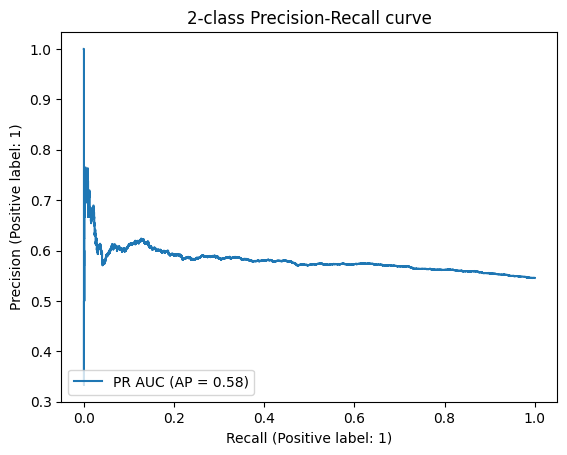

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

if train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.58

# Find the best threshold

ic| bound: 0.3
    prec_score: 0.54559
    obj_num: 6032
    obj_pct: 1.0
    obj_profit: 550
ic| bound: 0.31
    prec_score: 0.54577
    obj_num: 6030
    obj_pct: 1.0
    obj_profit: 552
ic| bound: 0.32
    prec_score: 0.5455
    obj_num: 6022
    obj_pct: 1.0
    obj_profit: 548
ic| bound: 0.33
    prec_score: 0.54576
    obj_num: 6010
    obj_pct: 1.0
    obj_profit: 550
ic| bound: 0.34
    prec_score: 0.54567
    obj_num: 5989
    obj_pct: 0.99
    obj_profit: 547
ic| bound: 0.35
    prec_score: 0.54619
    obj_num: 5954
    obj_pct: 0.99
    obj_profit: 550
ic| bound: 0.36
    prec_score: 0.5474
    obj_num: 5897
    obj_pct: 0.98
    obj_profit: 559
ic| bound: 0.37
    prec_score: 0.54813
    obj_num: 5838
    obj_pct: 0.97
    obj_profit: 562
ic| bound: 0.38
    prec_score: 0.5493
    obj_num: 5740
    obj_pct: 0.95
    obj_profit: 566
ic| bound: 0.39
    prec_score: 0.5512
    obj_num: 5615
    obj_pct: 0.93
    obj_profit: 575
ic| bound: 0.4
    prec_score: 0.55336
    obj_nu

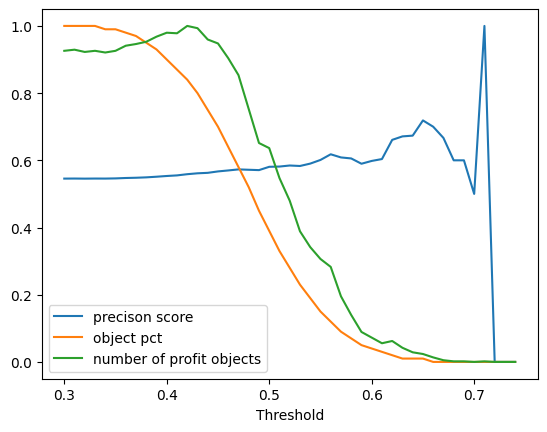

In [ ]:
from icecream import ic

if train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round(obj_num * prec_score - obj_num * (1 - prec_score))
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()